# MIDI-Trained Chord Recognition Model

## Data Preprocessing 

### 1. Load and Extract from midi_folder

In [41]:
import os
import json
import pretty_midi
import pandas as pd
import numpy as np
from collections import defaultdict
import mido
import io

# define chord type templates: intervals relative to root
CHORD_TEMPLATES = {
    "Major":         {0, 4, 7},
    "Minor":         {0, 3, 7},
    "Dominant 7th":  {0, 4, 7, 10},
    "Diminished":    {0, 3, 6},
    "Augmented":     {0, 4, 8},
}

PITCH_CLASS_NAMES = ['C', 'C#', 'D', 'D#', 'E', 'F',
                     'F#', 'G', 'G#', 'A', 'A#', 'B']

# normalize chord, removing octave transpositions 
def normalize_chord(chord_tuple):
    normalized_chord = {note % 12 for note in chord_tuple}  # keep only unique notes modulo 12
    return tuple(sorted(normalized_chord))

# identify and name chords 
def identify_named_chord(chord_tuple):
    if not chord_tuple:
        return "Unknown"

    pitch_classes = sorted({p % 12 for p in chord_tuple})
    for root in pitch_classes:
        transposed = sorted({(p - root) % 12 for p in pitch_classes})
        for label, template in CHORD_TEMPLATES.items():
            if set(transposed) == template:
                root_name = PITCH_CLASS_NAMES[root]
                return f"{root_name} {label}"
    return "Unknown"

# fixed mapping for chord vocab: all 12 roots * templates
def create_fixed_chord_vocab():
    ALL_CHORDS = [
        f"{pitch} {chord_type}"
        for pitch in PITCH_CLASS_NAMES
        for chord_type in CHORD_TEMPLATES.keys()
    ]
    chord_to_index = {chord: idx for idx, chord in enumerate(ALL_CHORDS)}
    return chord_to_index

# extract chord sequence
def midi_to_chord_sequence(midi_file, merge_threshold=0.3):
    #midi_data = pretty_midi.PrettyMIDI(midi_file)
    
    raw = mido.MidiFile(midi_file, clip=True)
    merged = mido.MidiFile() 
    merged.ticks_per_beat = raw.ticks_per_beat
    merged_track = mido.merge_tracks(raw.tracks)
    merged.tracks.append(merged_track)
    
    # dump to memory buffer
    buf = io.BytesIO()
    merged.save(file=buf)
    buf.seek(0)

    midi_data = pretty_midi.PrettyMIDI(buf)

    events = []
    # for each note, add two events: on/off
    for instrument in midi_data.instruments:
        if instrument.is_drum:
            continue
        for note in instrument.notes:
            events.append((note.start, 'on', note.pitch))
            events.append((note.end, 'off', note.pitch))
    
    events.sort(key=lambda x: x[0])

    active_notes = set()  # track notes that are in use
    chords = []  # final list
    previous_chord = None
    chord_start_time = None
    last_event_time = 0

    # if note is starting, add to active set
    # if note ending, remove it from active set
    for time, action, pitch in events:
        if action == 'on':
            active_notes.add(pitch)
        elif action == 'off':
            active_notes.discard(pitch)

        current_chord = normalize_chord(active_notes) if active_notes else None
        chord_label = identify_named_chord(current_chord) if current_chord else None

        # if chord changed
        if chord_label != previous_chord:
            if previous_chord is not None and chord_start_time is not None:
                if time - chord_start_time >= merge_threshold:
                    chords.append((round(chord_start_time, 3), round(time, 3), previous_chord))
            chord_start_time = time
            previous_chord = chord_label

        last_event_time = time

    # capture final chord if any
    if previous_chord is not None and chord_start_time is not None:
        chords.append((round(chord_start_time, 3), round(midi_data.get_end_time(), 3), previous_chord))

    return chords, midi_data

# timeframe-level feature extraction and align with chord labels
def extract_frame_level_data(chords, midi_data, chord_to_index, frame_hop=1):
    end_time = midi_data.get_end_time()
    frame_times = np.arange(0, end_time, frame_hop)

    chroma = midi_data.get_chroma(fs=int(1 / frame_hop))
    chroma = chroma.T  # transpose to shape (frames, 12)

    data = []

    for i, t in enumerate(frame_times):
        frame_feature = chroma[i] if i < len(chroma) else np.zeros(12)
        label = None
        for start, end, chord in chords:
            if start <= t < end:
                if chord in chord_to_index:
                    label = chord_to_index[chord]
                break
        if label is not None:
            data.append((t, frame_feature, label))
    return data


# process all midi files in the folder, save to CSV
def process_midi_folder(input_folder, chord_csv, frame_csv, frame_hop=1):
    chord_rows = []
    frame_rows = []
    chord_to_index = create_fixed_chord_vocab()

    for root, _, files in os.walk(input_folder):
        for fname in files:
            if not fname.lower().endswith(('.mid','.midi')): continue
            path = os.path.join(root, fname)
            rel = os.path.relpath(path, input_folder)
            try:
                chords, midi = midi_to_chord_sequence(path)
                # chord-level
                for st, ed, ch in chords:
                    chord_rows.append([rel, st, ed, ch])
                # frame-level
                frames = extract_frame_level_data(chords, midi, chord_to_index, frame_hop)
                for t, feat, lbl in frames:
                    frame_rows.append([rel, t, *feat, lbl])

            except Exception as e:
                print(f"[ERROR] {rel}: {e}")

    # save to csv
    chord_df = pd.DataFrame(chord_rows, columns=["filename","start_time","end_time","chord"])
    chord_df.to_csv(chord_csv, index=False)
    cols = [f"chroma_{i}" for i in range(12)]
    frame_df = pd.DataFrame(frame_rows, columns=["filename","time", *cols, "label"])
    frame_df.to_csv(frame_csv, index=False)

    print(f"✔ Saved chords to: {chord_csv}")
    print(f"✔ Saved frames to: {frame_csv}")
    return chord_to_index

### 2. Extract and Combine to csv file

In [42]:
# paths
output_dir = 'output'
os.makedirs(output_dir, exist_ok=True)

folder_to_process = 'lakh-midi-clean' # test use; change to 'lakh-midi-clean' for actual experiments

base = os.path.basename(folder_to_process.rstrip(os.sep))
chord_csv = os.path.join(output_dir, f"chord_dataset.csv")
frame_csv = os.path.join(output_dir, f"timeframe_dataset.csv")
vocab_json = os.path.join(output_dir, f"chord_vocab.json")

chord_to_index = process_midi_folder(folder_to_process, chord_csv, frame_csv)

with open(vocab_json, 'w') as f:
    json.dump(chord_to_index, f, indent=2)

[ERROR] ABBA/Ive_Been_Waiting_For_You.mid: undefined status byte 0xf9
[ERROR] ABBA/Voulez_Vous.1.mid: MIDI file has a largest tick of 5180253442760895903578768388112072, it is likely corrupt
[ERROR] Aerosmith/Pink.3.mid: 
[ERROR] Alice_in_Chains/Sludge_Factory.mid: 
[ERROR] Amedeo_Minghi/Decenni.1.mid: 
[ERROR] Amos,_Tori/The_Wrong_Band.mid: Could not decode key with 5 flats and mode 255
[ERROR] Beastie_Boys/Girls.mid: Could not decode key with 1 flats and mode 255
[ERROR] Bee_Gees/How_Can_You_Mend_a_Broken_Heart.1.mid: MIDI file has a largest tick of 12884927490, it is likely corrupt
[ERROR] Bee_Gees/Stayin_Alive.3.mid: Message length 2093056 exceeds maximum length 1000000
[ERROR] Bee_Gees/Too_Much_Heaven.mid: undefined status byte 0xfd
[ERROR] Billy_Joel/Movin_Out_Anthonys_Song_.mid: Could not decode key with 1 flats and mode 255
[ERROR] Blondie/Dreaming.mid: MIDI file has a largest tick of 4312862115, it is likely corrupt
[ERROR] Bon_Jovi/Blaze_of_Glory.2.mid: 
[ERROR] Brian_McKnigh

### 3. One-hot Encoding

In [43]:
# one-hot encoding 
import pandas as pd
import numpy as np
import os
import json

output_dir = "output"
os.makedirs(output_dir, exist_ok=True)

frame_csv_path = "output/timeframe_dataset.csv"
chord_vocab_path = "output/chord_vocab.json"
output_onehot_csv_path = os.path.join(output_dir, "timeframe_onehot.csv")


# load from JSON file
with open(chord_vocab_path, "r") as f:
    chord_to_index = json.load(f)

# reverse
chord_to_index = {str(k): v for k, v in chord_to_index.items()}


def one_hot_encode_labels(label_indices, num_classes):
    return np.eye(num_classes)[label_indices]

# load original timeframe-level dataset
df = pd.read_csv(frame_csv_path)

# get label col
label_indices = df["label"].astype(int).values

# one-hot encoding 
num_classes = len(chord_to_index)
one_hot = one_hot_encode_labels(label_indices, num_classes)

# create DataFrame 
one_hot_columns = [f"class_{i}" for i in range(num_classes)]
one_hot_df = pd.DataFrame(one_hot, columns=one_hot_columns)

# combine with filename + time 
minimal_df = df[["filename", "time"]].reset_index(drop=True)
result_df = pd.concat([minimal_df, one_hot_df], axis=1)

result_df.to_csv(output_onehot_csv_path, index=False)

print(f"One-hot encoded data saved to {output_onehot_csv_path}")

One-hot encoded data saved to output/timeframe_onehot.csv


## Baseline Model: SVM

In [44]:
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

frame_csv_path = "output/timeframe_dataset.csv"
df = pd.read_csv(frame_csv_path)

# split to train and test dataset
feature_cols = [f"chroma_{i}" for i in range(12)]
X = df[feature_cols].values
y = df["label"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# RBF kernel 
svm_model = SVC()
svm_model.fit(X_train_scaled, y_train)

y_pred = svm_model.predict(X_test_scaled)

# print confusion metrics with zero_division fix
print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.63      0.62      6535
           1       0.60      0.53      0.57      1207
           2       0.46      0.36      0.40       404
           3       0.00      0.00      0.00        40
           4       0.60      0.12      0.20        49
           5       0.58      0.60      0.59      1616
           6       0.64      0.51      0.57       800
           7       0.46      0.19      0.27       127
           8       0.45      0.09      0.14        58
           9       0.33      0.12      0.18        32
          10       0.57      0.61      0.59      5349
          11       0.62      0.52      0.57      1941
          12       0.41      0.30      0.35       508
          13       0.33      0.15      0.21        53
          14       0.44      0.10      0.16        40
          15       0.57      0.60      0.58      2385
          16       0.63      0.53      0.58       667
    

## Deep Learning Models

### Reorganize timing data

In [45]:
import torch

# auto-select device:
if torch.cuda.is_available():
    device = torch.device("cuda")
    backend = "CUDA"
elif getattr(torch.backends, "mps", None) is not None \
     and torch.backends.mps.is_available():
    device = torch.device("mps")
    backend = "MPS (Apple Silicon)"
else:
    device = torch.device("cpu")
    backend = "CPU"

print(f"Using device: {device}  |  backend: {backend}")

Using device: cuda  |  backend: CUDA


In [46]:
import numpy as np
import pandas as pd

def build_sequence_tensor(
    frame_df: pd.DataFrame,
    seq_len: int,
    num_feat: int = 12,
    num_classes: int = 24,
    to_torch: bool = False,
    device: str | None = None,
):

    groups = frame_df.groupby("filename", sort=False)
    n_song = len(groups)

    X_seq = np.zeros((n_song, seq_len, num_feat), dtype=np.float32)
    y_seq = np.zeros((n_song, seq_len),        dtype=np.int64)

    for idx, (_, g) in enumerate(groups):
        g = g.sort_values("time")

        x = g[[f"chroma_{i}" for i in range(num_feat)]].to_numpy(dtype=np.float32)
        y = g["label"].to_numpy(dtype=np.int64)

        pad = max(seq_len - len(x), 0)
        X_seq[idx] = np.pad(x, ((0, pad), (0, 0)), mode="constant")[:seq_len]
        y_seq[idx] = np.pad(y, (0, pad), mode="constant")[:seq_len]

    # one-hot via NumPy (no TF)
    eye = np.eye(num_classes, dtype=np.float32)
    y_seq_ohe = eye[y_seq]                    # (N, seq_len, C)

    if to_torch:
        import torch
        X_seq      = torch.tensor(X_seq,      device=device)
        y_seq_ohe  = torch.tensor(y_seq_ohe,  device=device)

    return X_seq, y_seq_ohe

In [47]:
import json, pandas as pd, numpy as np, torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

# load data
df = pd.read_csv("output/timeframe_dataset.csv")
num_classes = len(json.load(open("output/chord_vocab.json")))

X_seq, y_seq_ohe = build_sequence_tensor(
    frame_df     = df,
    seq_len      = 64,
    num_feat     = 12,
    num_classes  = num_classes,
    to_torch     = True,
    device       = device
)

# train / val split
X_tr, X_te, y_tr, y_te = train_test_split(
    X_seq, y_seq_ohe,
    test_size   = 0.20,
    random_state= 42,
    shuffle     = True
)

y_tr_idx = y_tr.argmax(dim=-1)
y_te_idx = y_te.argmax(dim=-1)


batch_size = 16
train_dl = DataLoader(
    TensorDataset(X_tr.float(), y_tr_idx.long()),
    batch_size = batch_size,
    shuffle    = True
)
val_dl = DataLoader(
    TensorDataset(X_te.float(), y_te_idx.long()),
    batch_size = batch_size,
    shuffle    = False
)

seq_len  = X_tr.size(1)
num_feat = X_tr.size(2) 

## 1. CNN Model

In [48]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import DataLoader, TensorDataset

# model
class ChromaCNN_Frame(nn.Module):
    def __init__(self, n_feat, n_class, hidden=128, p_drop=0.3):
        super().__init__()

        def same_conv(cin, cout, k, dil=1):
            pad = dil * (k - 1) // 2         # IMPORTANT
            return nn.Sequential(
                nn.Conv1d(cin, cout, k, padding=pad, dilation=dil),
                nn.BatchNorm1d(cout), nn.ReLU()
            )

        self.backbone = nn.Sequential(
            same_conv(n_feat, 64, 3, 1),
            same_conv(64, 128, 5, 2),                # pad=4
            same_conv(128, hidden, 7, 4),            # pad=12
            nn.Dropout(p_drop)
        )
        self.cls = nn.Conv1d(hidden, n_class, 1)

    def forward(self, x):             # (B, T, F)
        x = x.transpose(1, 2)         # (B, F, T)
        h = self.backbone(x)          # (B, hidden, T)
        y = self.cls(h).transpose(1, 2)
        return y                      # (B, T, C)


# init
cnn_model = ChromaCNN_Frame(num_feat, num_classes).to(device)
criterion  = nn.CrossEntropyLoss()
optimizer  = torch.optim.Adam(cnn_model.parameters(), lr=1e-3)

epochs, patience = 30, 3
best_loss, patience_ctr = np.inf, 0
os.makedirs("checkpoints", exist_ok=True)
best_ckpt = "checkpoints/best_cnn.pt"
last_ckpt = "checkpoints/last_cnn.pt"


In [49]:
# training loop
num_epochs = 20
for epoch in range(1, epochs + 1):
    cnn_model.train()
    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = cnn_model(xb)
        loss   = criterion(logits.reshape(-1, num_classes), yb.reshape(-1))
        loss.backward()
        optimizer.step()

    # validation
    cnn_model.eval(); val_loss = 0.
    with torch.no_grad():
        for xb, yb in val_dl:
            xb, yb = xb.to(device), yb.to(device)
            loss = criterion(cnn_model(xb).reshape(-1, num_classes),
                             yb.reshape(-1))
            val_loss += loss.item() * xb.size(0)
    val_loss /= len(val_dl.dataset)
    print(f"[CNN] Epoch {epoch:02d}  val_loss={val_loss:.4f}")
    torch.save(cnn_model.state_dict(), last_ckpt)

    if val_loss < best_loss:
        best_loss, patience_ctr = val_loss, 0
        torch.save(cnn_model.state_dict(), best_ckpt)
    else:
        patience_ctr += 1
        if patience_ctr >= patience:
            print("Early stopping.\n"); break

cnn_model.load_state_dict(torch.load(best_ckpt, map_location=device))
print("✓ CNN training done!")



[CNN] Epoch 01  val_loss=0.8525
[CNN] Epoch 02  val_loss=0.7911
[CNN] Epoch 03  val_loss=0.7660
[CNN] Epoch 04  val_loss=0.7624
[CNN] Epoch 05  val_loss=0.7368
[CNN] Epoch 06  val_loss=0.7274
[CNN] Epoch 07  val_loss=0.7168
[CNN] Epoch 08  val_loss=0.7130
[CNN] Epoch 09  val_loss=0.7057
[CNN] Epoch 10  val_loss=0.7058
[CNN] Epoch 11  val_loss=0.7024
[CNN] Epoch 12  val_loss=0.6990
[CNN] Epoch 13  val_loss=0.7021
[CNN] Epoch 14  val_loss=0.6963
[CNN] Epoch 15  val_loss=0.6975
[CNN] Epoch 16  val_loss=0.6944
[CNN] Epoch 17  val_loss=0.6970
[CNN] Epoch 18  val_loss=0.7018
[CNN] Epoch 19  val_loss=0.6934
[CNN] Epoch 20  val_loss=0.6943
[CNN] Epoch 21  val_loss=0.6983
[CNN] Epoch 22  val_loss=0.7057
Early stopping.

✓ CNN training done!


In [50]:
# evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np, torch

pad_id = num_classes
mask_pad = True               # =False not ignore padding

cnn_model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for xb, yb in val_dl:
        xb, yb = xb.to(device), yb.to(device)     # xb:(B,T,F)  yb:(B,T)
        logits = cnn_model(xb)                    # (B,T,C)
        preds  = logits.argmax(-1)                # (B,T)

        if mask_pad:
            valid = (yb != pad_id)
            all_preds.extend(preds[valid].cpu().numpy())
            all_labels.extend(yb[valid].cpu().numpy())
        else:
            all_preds.extend(preds.cpu().numpy().ravel())
            all_labels.extend(yb.cpu().numpy().ravel())


acc = accuracy_score(all_labels, all_preds)
print(f"Frame accuracy : {acc:.4f}\n")

print("Classification Report:")
print(classification_report(all_labels, all_preds, zero_division=0))

print("Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))



Frame accuracy : 0.7979

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96     49960
           1       0.66      0.67      0.66       956
           2       0.47      0.30      0.37       308
           3       1.00      0.05      0.09        43
           4       0.44      0.16      0.23        45
           5       0.66      0.68      0.67      1467
           6       0.64      0.66      0.65       709
           7       0.54      0.13      0.21       117
           8       0.80      0.09      0.15        47
           9       1.00      0.04      0.07        28
          10       0.61      0.69      0.65      4232
          11       0.64      0.62      0.63      1595
          12       0.46      0.33      0.39       366
          13       0.62      0.16      0.26        31
          14       0.67      0.09      0.16        22
          15       0.62      0.66      0.64      2082
          16       0.57      0.67

## 2. RNN Model

In [51]:
import os, torch, numpy as np
from torch import nn

# define RNN model
class SimpleRNNModel(nn.Module):
    def __init__(self, n_feat, n_classes, hidden=64):
        super().__init__()
        self.rnn = nn.RNN(
            input_size=n_feat,
            hidden_size=hidden,
            batch_first=True,
            nonlinearity="tanh"
        )
        self.fc = nn.Linear(hidden, n_classes)

    def forward(self, x):                 # x: (B, T, F)
        out, _ = self.rnn(x)              # (B, T, H)
        return self.fc(out)               # (B, T, C)

# init
rnn_model = SimpleRNNModel(num_feat, num_classes).to(device)
criterion  = nn.CrossEntropyLoss()
optimizer  = torch.optim.Adam(rnn_model.parameters(), lr=1e-3)

epochs, patience = 30, 3
best_loss        = np.inf
patience_ctr     = 0

# checkpoint paths
os.makedirs("checkpoints", exist_ok=True)
best_ckpt = "checkpoints/best_rnn.pt"
last_ckpt = "checkpoints/last_rnn.pt"

# training loop
for epoch in range(1, epochs + 1):
    rnn_model.train()
    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = rnn_model(xb)
        loss = criterion(logits.reshape(-1, num_classes), yb.reshape(-1))
        loss.backward()
        optimizer.step()

    # validation
    rnn_model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_dl:
            xb, yb = xb.to(device), yb.to(device)
            logits = rnn_model(xb)
            loss = criterion(logits.reshape(-1, num_classes), yb.reshape(-1))
            val_loss += loss.item() * xb.size(0)
    val_loss /= len(val_dl.dataset)

    print(f"Epoch {epoch:02d}  val_loss={val_loss:.4f}")
    torch.save(rnn_model.state_dict(), last_ckpt)            # always save last

    if val_loss < best_loss:                                 # save best
        best_loss = val_loss
        patience_ctr = 0
        torch.save(rnn_model.state_dict(), best_ckpt)
    else:
        patience_ctr += 1
        if patience_ctr >= patience:
            print("Early stopping.\n")
            break

# restore best
ckpt_to_load = best_ckpt if os.path.exists(best_ckpt) else last_ckpt
rnn_model.load_state_dict(torch.load(ckpt_to_load, map_location=device))
print(f"✓ RNN training done!")

Epoch 01  val_loss=1.0196
Epoch 02  val_loss=0.9332
Epoch 03  val_loss=0.8768
Epoch 04  val_loss=0.8495
Epoch 05  val_loss=0.8251
Epoch 06  val_loss=0.7997
Epoch 07  val_loss=0.7919
Epoch 08  val_loss=0.7803
Epoch 09  val_loss=0.7746
Epoch 10  val_loss=0.7766
Epoch 11  val_loss=0.7639
Epoch 12  val_loss=0.7617
Epoch 13  val_loss=0.7570
Epoch 14  val_loss=0.7570
Epoch 15  val_loss=0.7737
Epoch 16  val_loss=0.7571
Epoch 17  val_loss=0.7506
Epoch 18  val_loss=0.7479
Epoch 19  val_loss=0.7473
Epoch 20  val_loss=0.7460
Epoch 21  val_loss=0.7434
Epoch 22  val_loss=0.7449
Epoch 23  val_loss=0.7474
Epoch 24  val_loss=0.7492
Early stopping.

✓ RNN training done!


## 3. BiLSTM Model

In [52]:
import os, torch, numpy as np
from torch import nn

# bidirectional LSTM
class BiLSTMModel(nn.Module):
    def __init__(self, n_feat, n_classes, hidden=64):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=n_feat,
            hidden_size=hidden,
            batch_first=True,
            bidirectional=True
        )
        self.fc = nn.Linear(hidden * 2, n_classes)

    def forward(self, x):                  # x: (B, T, F)
        out, _ = self.lstm(x)              # (B, T, 2H)
        out = self.fc(out)                 # (B, T, C)
        return out

# init
lstm_model = BiLSTMModel(num_feat, num_classes).to(device)
criterion   = nn.CrossEntropyLoss()
optimizer   = torch.optim.Adam(lstm_model.parameters(), lr=1e-3)

epochs, patience = 30, 3
best_loss        = np.inf
patience_ctr     = 0

# checkpoint directory
os.makedirs("checkpoints", exist_ok=True)
best_ckpt  = "checkpoints/best_lstm.pt"
last_ckpt  = "checkpoints/last_lstm.pt"

# training loop
for epoch in range(1, epochs + 1):
    lstm_model.train()
    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = lstm_model(xb)
        loss   = criterion(logits.reshape(-1, num_classes),
                           yb.reshape(-1))
        loss.backward()
        optimizer.step()

    # validation
    lstm_model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_dl:
            xb, yb = xb.to(device), yb.to(device)
            logits = lstm_model(xb)
            loss   = criterion(logits.reshape(-1, num_classes),
                               yb.reshape(-1))
            val_loss += loss.item() * xb.size(0)
    val_loss /= len(val_dl.dataset)

    print(f"Epoch {epoch:02d}  val_loss={val_loss:.4f}")

    torch.save(lstm_model.state_dict(), last_ckpt)

    # save best & early stopping
    if val_loss < best_loss:
        best_loss = val_loss
        patience_ctr = 0
        torch.save(lstm_model.state_dict(), best_ckpt)
    else:
        patience_ctr += 1
        if patience_ctr >= patience:
            print("Early stopping.\n")
            break

# load best
ckpt_to_load = best_ckpt if os.path.exists(best_ckpt) else last_ckpt
lstm_model.load_state_dict(torch.load(ckpt_to_load, map_location=device))
print(f"✓ LSTM training done!")


Epoch 01  val_loss=0.8427
Epoch 02  val_loss=0.7838
Epoch 03  val_loss=0.7579
Epoch 04  val_loss=0.7421
Epoch 05  val_loss=0.7310
Epoch 06  val_loss=0.7238
Epoch 07  val_loss=0.7183
Epoch 08  val_loss=0.7135
Epoch 09  val_loss=0.7101
Epoch 10  val_loss=0.7064
Epoch 11  val_loss=0.7044
Epoch 12  val_loss=0.7023
Epoch 13  val_loss=0.7003
Epoch 14  val_loss=0.6972
Epoch 15  val_loss=0.6994
Epoch 16  val_loss=0.6951
Epoch 17  val_loss=0.6952
Epoch 18  val_loss=0.6960
Epoch 19  val_loss=0.6964
Early stopping.

✓ LSTM training done!


## 4. Hybrid Model (CNN+BiLSTM)

In [53]:
import torch, torch.nn as nn
import numpy as np, os
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


class CNN_BiLSTM(nn.Module):
    def __init__(self, n_feat, n_class,
                 cnn_hidden=128, lstm_hidden=64, p_drop=0.3):
        super().__init__()

        def same_conv(cin, out_channels, k, dil=1):
            pad = dil * (k - 1) // 2
            return nn.Sequential(
                nn.Conv1d(cin, out_channels, k, padding=pad, dilation=dil),
                nn.BatchNorm1d(out_channels), nn.ReLU()
            )

        # local convolution
        self.cnn = nn.Sequential(
            same_conv(n_feat, 64, 3, 1),
            same_conv(64,  cnn_hidden, 5, 1)
        )
        # long-term dependency
        self.lstm = nn.LSTM(cnn_hidden, lstm_hidden,
                            batch_first=True, bidirectional=True)
        self.drop = nn.Dropout(p_drop)
        self.fc   = nn.Linear(lstm_hidden * 2, n_class)

    def forward(self, x):              # x:(B,T,F)
        x = x.transpose(1, 2)          # (B,F,T)
        h = self.cnn(x).transpose(1, 2)# (B,T,Hc)  len = T
        o, _ = self.lstm(h)            # (B,T,2Hl)
        o = self.drop(o)
        return self.fc(o)              # (B,T,C)

pad_id        = num_classes            # 24
total_classes = num_classes + 1        # 25

hyb_model = CNN_BiLSTM(num_feat, total_classes).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=pad_id)
optimizer = torch.optim.Adam(hyb_model.parameters(), lr=1e-3)

best_loss, wait = np.inf, 0
os.makedirs("checkpoints", exist_ok=True)
best_ckpt, last_ckpt = "checkpoints/best_hyb.pt", "checkpoints/last_hyb.pt"



In [54]:
# training loop
epochs, patience = 30, 3

for ep in range(1, epochs + 1):
    # train
    hyb_model.train()
    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = hyb_model(xb)                             # (B,T,25)
        loss   = criterion(logits.reshape(-1, logits.size(-1)),
                           yb.reshape(-1))
        loss.backward(); optimizer.step()

    # val
    hyb_model.eval(); val_loss = 0.
    with torch.no_grad():
        for xb, yb in val_dl:
            xb, yb = xb.to(device), yb.to(device)
            logits = hyb_model(xb)
            loss   = criterion(logits.reshape(-1, logits.size(-1)),
                               yb.reshape(-1))
            val_loss += loss.item() * xb.size(0)
    val_loss /= len(val_dl.dataset)
    print(f"[HYB] Ep{ep:02d} val_loss={val_loss:.4f}")

    torch.save(hyb_model.state_dict(), last_ckpt)
    if val_loss < best_loss:
        best_loss, wait = val_loss, 0
        torch.save(hyb_model.state_dict(), best_ckpt)
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping."); break

hyb_model.load_state_dict(torch.load(best_ckpt, map_location=device))
print("✓ Hybrid CNN+BiLSTM training done!")



[HYB] Ep01 val_loss=0.8375
[HYB] Ep02 val_loss=0.7783
[HYB] Ep03 val_loss=0.7519
[HYB] Ep04 val_loss=0.7351
[HYB] Ep05 val_loss=0.7222
[HYB] Ep06 val_loss=0.6985
[HYB] Ep07 val_loss=0.6887
[HYB] Ep08 val_loss=0.6829
[HYB] Ep09 val_loss=0.6728
[HYB] Ep10 val_loss=0.6700
[HYB] Ep11 val_loss=0.6640
[HYB] Ep12 val_loss=0.6618
[HYB] Ep13 val_loss=0.6593
[HYB] Ep14 val_loss=0.6735
[HYB] Ep15 val_loss=0.6540
[HYB] Ep16 val_loss=0.6472
[HYB] Ep17 val_loss=0.6478
[HYB] Ep18 val_loss=0.6400
[HYB] Ep19 val_loss=0.6430
[HYB] Ep20 val_loss=0.6542
[HYB] Ep21 val_loss=0.6394
[HYB] Ep22 val_loss=0.6360
[HYB] Ep23 val_loss=0.6335
[HYB] Ep24 val_loss=0.6349
[HYB] Ep25 val_loss=0.6343
[HYB] Ep26 val_loss=0.6319
[HYB] Ep27 val_loss=0.6346
[HYB] Ep28 val_loss=0.6347
[HYB] Ep29 val_loss=0.6334
Early stopping.
✓ Hybrid CNN+BiLSTM training done!


In [55]:
# evaluation
pad_id = num_classes
mask_pad = True

hyb_model.eval()
all_p, all_l = [], []

with torch.no_grad():
    for xb, yb in val_dl:
        xb, yb = xb.to(device), yb.to(device)
        preds  = hyb_model(xb).argmax(-1)          # (B,T)

        if mask_pad:
            valid = (yb != pad_id)
            all_p.extend(preds[valid].cpu().numpy())
            all_l.extend(yb[valid].cpu().numpy())
        else:
            all_p.extend(preds.cpu().numpy().ravel())
            all_l.extend(yb.cpu().numpy().ravel())

acc = accuracy_score(all_l, all_p)
print(f"Frame accuracy : {acc:.4f}\n")
print(classification_report(all_l, all_p, zero_division=0))
print(confusion_matrix(all_l, all_p))


Frame accuracy : 0.8132

              precision    recall  f1-score   support

           0       0.96      0.97      0.97     49960
           1       0.66      0.74      0.70       956
           2       0.52      0.40      0.45       308
           3       0.81      0.30      0.44        43
           4       0.50      0.16      0.24        45
           5       0.69      0.72      0.70      1467
           6       0.68      0.69      0.68       709
           7       0.67      0.30      0.41       117
           8       0.42      0.17      0.24        47
           9       0.62      0.18      0.28        28
          10       0.64      0.69      0.67      4232
          11       0.68      0.63      0.65      1595
          12       0.53      0.39      0.45       366
          13       0.33      0.16      0.22        31
          14       0.67      0.27      0.39        22
          15       0.63      0.69      0.66      2082
          16       0.64      0.65      0.64       579
  

## Evaluation

In [57]:
import numpy as np, json, mir_eval, torch, pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# chord vocab
with open("output/chord_vocab.json") as f:
    chord_to_idx = json.load(f)
idx_to_chord = {int(v): k for k, v in chord_to_idx.items()}

MIREX_MAPPING = {
    "Major": "maj",
    "Minor": "min",
    "Dominant 7th": "7",
    "Diminished": "dim",
    "Augmented": "aug"
}

def ints_to_chords(int_arr):
    out = []
    for i in int_arr.flatten():
        txt = idx_to_chord.get(int(i), "N")
        if txt in ("Unknown", "N"):
            out.append("N"); continue
        try:
            root, qual = txt.split(" ", 1)
            out.append(f"{root}:{MIREX_MAPPING.get(qual,'maj')}")
        except ValueError:
            out.append("N")
    return out


In [58]:
def predict_np(model, X_np, batch=128):
    model.eval(); outs=[]
    with torch.no_grad():
        for i in range(0, len(X_np), batch):
            xb = torch.tensor(X_np[i:i+batch], dtype=torch.float32, device=device)
            logits = model(xb)                     # (B,T,C)
            outs.append(torch.softmax(logits, -1).cpu().numpy())
    return np.concatenate(outs, 0)                 # (N,T,C)


In [59]:
import numpy as np, torch, mir_eval

def evaluate_chord_predictions(name,
                               y_pred_prob,
                               y_true_ohe,
                               frame_rate: float = 1.0,
                               pad_id: int | None = None,
                               verbose=True):

    # ensure NumPy
    if torch.is_tensor(y_pred_prob):
        y_pred_prob = y_pred_prob.detach().cpu().numpy()
    if torch.is_tensor(y_true_ohe):
        y_true_ohe  = y_true_ohe.detach().cpu().numpy()

    # flatten class indices
    y_pred_int = y_pred_prob.argmax(-1).ravel()
    y_true_int = y_true_ohe.argmax(-1).ravel()

    # optional PAD filtering
    if pad_id is not None:
        mask = y_true_int != pad_id
        y_pred_int, y_true_int = y_pred_int[mask], y_true_int[mask]

    # convert to MIREX chord strings
    est_labels = ints_to_chords(y_pred_int)
    ref_labels = ints_to_chords(y_true_int)

    n = len(y_true_int)
    intervals = np.column_stack([np.arange(n)/frame_rate,
                                 (np.arange(n)+1)/frame_rate])

    result = mir_eval.chord.evaluate(intervals, ref_labels,
                                     intervals, est_labels)

    score_names = list(result.keys())
    scores      = list(result.values())
    frame_acc   = (y_pred_int == y_true_int).mean()

    if verbose:
        print(f"\n=== {name} ===")
        for k, v in zip(score_names, scores):
            print(f"{k:>10}: {v:.4f}")
        print(f"{'frame_acc':>10}: {frame_acc:.4f}")

    out = dict(result)
    out["frame_acc"] = frame_acc
    out["model"]     = name

    return out


def evaluate_models(model_dict, X_test, y_test_ohe, pad_id):
    rows=[]
    for n,m in model_dict.items():
        probs = predict_np(m, X_test)
        rows.append(evaluate_chord_predictions(n, probs, y_test_ohe,
                                               frame_rate=1.0,
                                               pad_id=pad_id,
                                               verbose=False))
        
    return pd.DataFrame(rows).set_index("model").round(4)


In [60]:
# load best checkpoints
cnn_model = ChromaCNN_Frame(num_feat, num_classes).to(device)
cnn_model.load_state_dict(torch.load("checkpoints/best_cnn.pt",
                                     map_location=device))

hyb_model = CNN_BiLSTM(num_feat, total_classes).to(device)
hyb_model.load_state_dict(torch.load("checkpoints/best_hyb.pt",
                                     map_location=device))

models = {"RNN": rnn_model,
          "LSTM": lstm_model,
          "CNN": cnn_model,
          "CNN+BiLSTM": hyb_model}

df = evaluate_models(models, X_te, y_te, pad_id)
print("\n=== Summary ==="); display(df)



/tmp/ipykernel_1594/2778293201.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb = torch.tensor(X_np[i:i+batch], dtype=torch.float32, device=device)



=== Summary ===


,thirds,thirds_inv,triads,triads_inv,tetrads,tetrads_inv,root,mirex,majmin,majmin_inv,sevenths,sevenths_inv,underseg,overseg,seg,frame_acc
model,,,,,,,,,,,,,,,,
RNN,0.7977,0.7977,0.7973,0.7973,0.7867,0.7867,0.8023,0.7978,0.8018,0.8018,0.7911,0.7911,0.8762,0.9213,0.8762,0.7867
LSTM,0.8034,0.8034,0.8029,0.8029,0.7935,0.7935,0.8070,0.8035,0.8072,0.8072,0.7977,0.7977,0.8617,0.9306,0.8617,0.7935
CNN,0.8090,0.8090,0.8087,0.8087,0.7979,0.7979,0.8132,0.8091,0.8133,0.8133,0.8024,0.8024,0.8665,0.9307,0.8665,0.7979
CNN+BiLSTM,0.8227,0.8227,0.8223,0.8223,0.8132,0.8132,0.8264,0.8228,0.8265,0.8265,0.8174,0.8174,0.8692,0.9392,0.8692,0.8132


In [68]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
import torch

def plot_confusion_matrices(model_dict, X_test, y_test_ohe, pad_id, 
                            top_n_classes=10, figsize=(20, 15)):
    # Get true class indices from one-hot encoded labels
    y_true = y_test_ohe.argmax(-1).ravel()
    
    # Convert to CPU numpy if needed
    if isinstance(y_true, torch.Tensor):
        y_true = y_true.detach().cpu().numpy()
    
    # Remove padding
    if pad_id is not None:
        mask = y_true != pad_id
        y_true = y_true[mask]
    
    # Get most common class indices
    unique, counts = np.unique(y_true, return_counts=True)
    top_classes = unique[np.argsort(-counts)][:top_n_classes]
    top_class_names = [idx_to_chord[int(i)] for i in top_classes]
    
    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    axes = axes.flatten()
    
    for i, (name, model) in enumerate(model_dict.items()):
        # Predict and flatten
        y_pred = predict_np(model, X_test).argmax(-1).ravel()
        
        # Convert to CPU numpy if needed
        if isinstance(y_pred, torch.Tensor):
            y_pred = y_pred.detach().cpu().numpy()
        
        # Remove padding
        if pad_id is not None:
            y_pred = y_pred[mask]
        
        # Keep only top classes
        mask_top = np.isin(y_true, top_classes)
        y_true_top = y_true[mask_top]
        y_pred_top = y_pred[mask_top]
        
        # Confusion matrix
        cm = confusion_matrix(y_true_top, y_pred_top, labels=top_classes, normalize='true')
        
        # Plot
        ax = axes[i]
        sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues',
                    xticklabels=top_class_names, yticklabels=top_class_names, ax=ax)
        ax.set_title(f'{name} - Top {top_n_classes} Chords Confusion Matrix')
        ax.set_xlabel('Predicted')
        ax.set_ylabel('True')
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
        plt.setp(ax.get_yticklabels(), rotation=0)

    plt.tight_layout()
    return fig


In [69]:
# plot performance comparison function
def plot_performance_comparison(results_df, figsize=(12, 10)):
    # metrics to plot
    metrics = ['root', 'majmin', 'mirex', 'thirds', 'triads', 'tetrads', 'sevenths', 'frame_acc']
    
    fig, axes = plt.subplots(len(metrics) // 2 + len(metrics) % 2, 2, figsize=figsize)
    axes = axes.flatten()
    
    for i, metric in enumerate(metrics):
        ax = axes[i]
        results_df[metric].plot(kind='bar', ax=ax, color='skyblue', edgecolor='black')
        ax.set_title(f'{metric} Score Comparison')
        ax.set_ylim(0, 1)
        ax.set_ylabel('Score')
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        
        for j, v in enumerate(results_df[metric]):
            ax.text(j, v + 0.01, f'{v:.3f}', ha='center')
    
    plt.tight_layout()
    return fig

# radar chart for model comparison by metrics
def plot_radar_chart(results_df, figsize=(10, 8)):
    # metrics
    metrics = ['root', 'majmin', 'mirex', 'thirds', 'triads', 'sevenths', 'frame_acc']
    
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, polar=True)
    
    N = len(metrics)
    
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1] 
    
    plt.xticks(angles[:-1], metrics)
    
    # plot on different models
    for model_name in results_df.index:
        values = results_df.loc[model_name, metrics].values.tolist()
        values += values[:1] 

        ax.plot(angles, values, linewidth=2, linestyle='solid', label=model_name)
        ax.fill(angles, values, alpha=0.1)
        
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.title('Model Performance Comparison', size=15)
    
    return fig

/tmp/ipykernel_1594/2778293201.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb = torch.tensor(X_np[i:i+batch], dtype=torch.float32, device=device)
/tmp/ipykernel_1594/2778293201.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb = torch.tensor(X_np[i:i+batch], dtype=torch.float32, device=device)
/tmp/ipykernel_1594/2778293201.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb = torch.tensor(X_np[i:i+batch], dtype=torch.float32, device=device)
/tmp/ipykernel_1594/2778293201.py:5: UserWarning: To copy construct from a tensor,

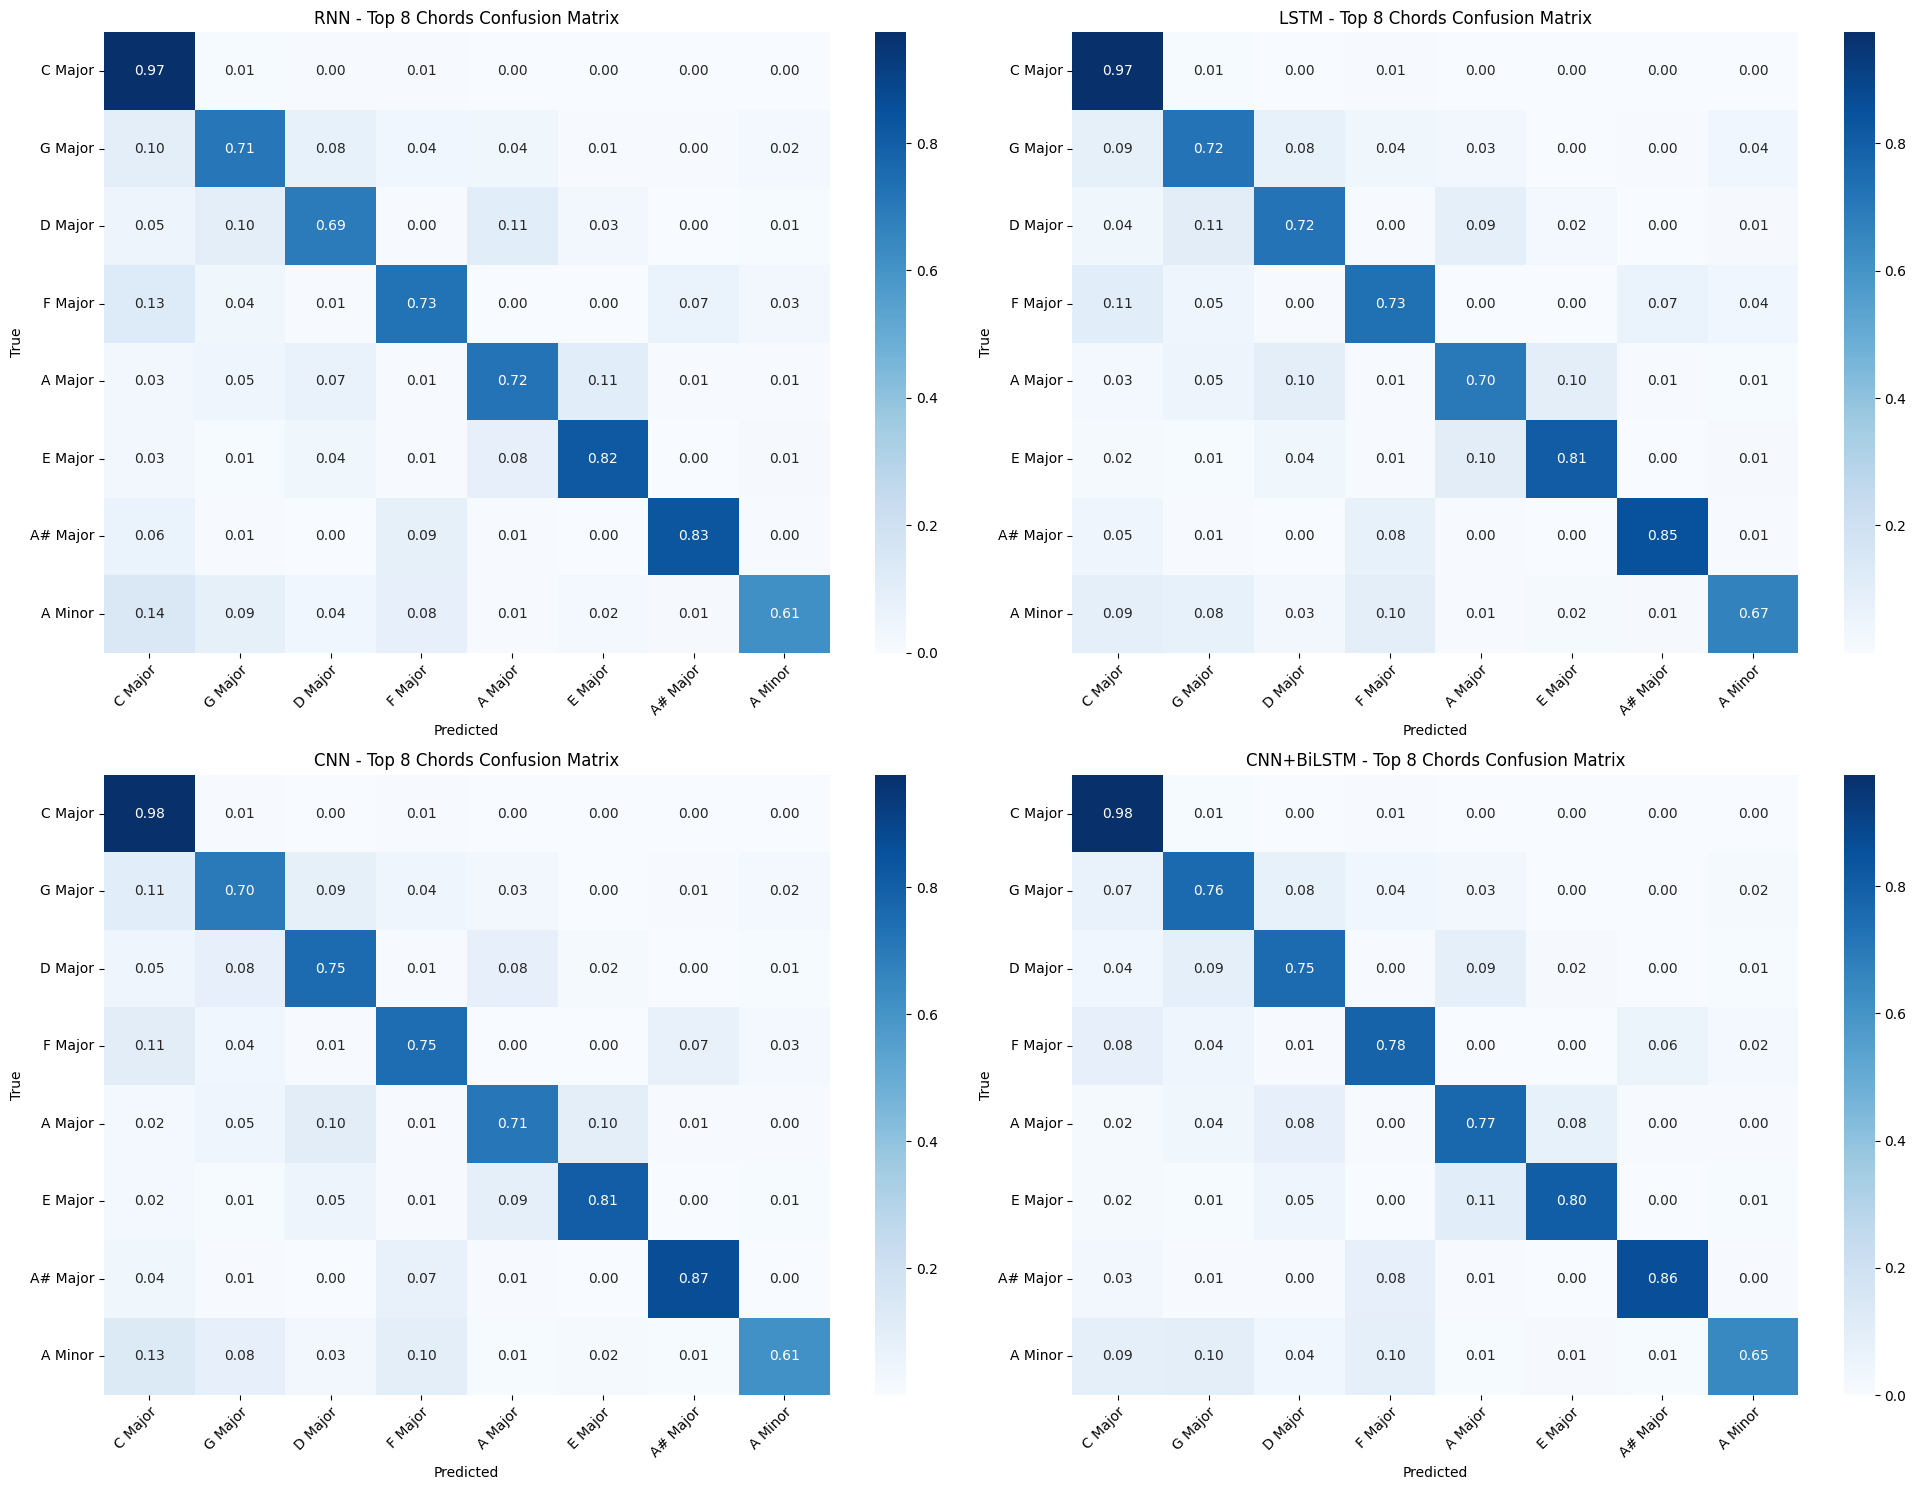

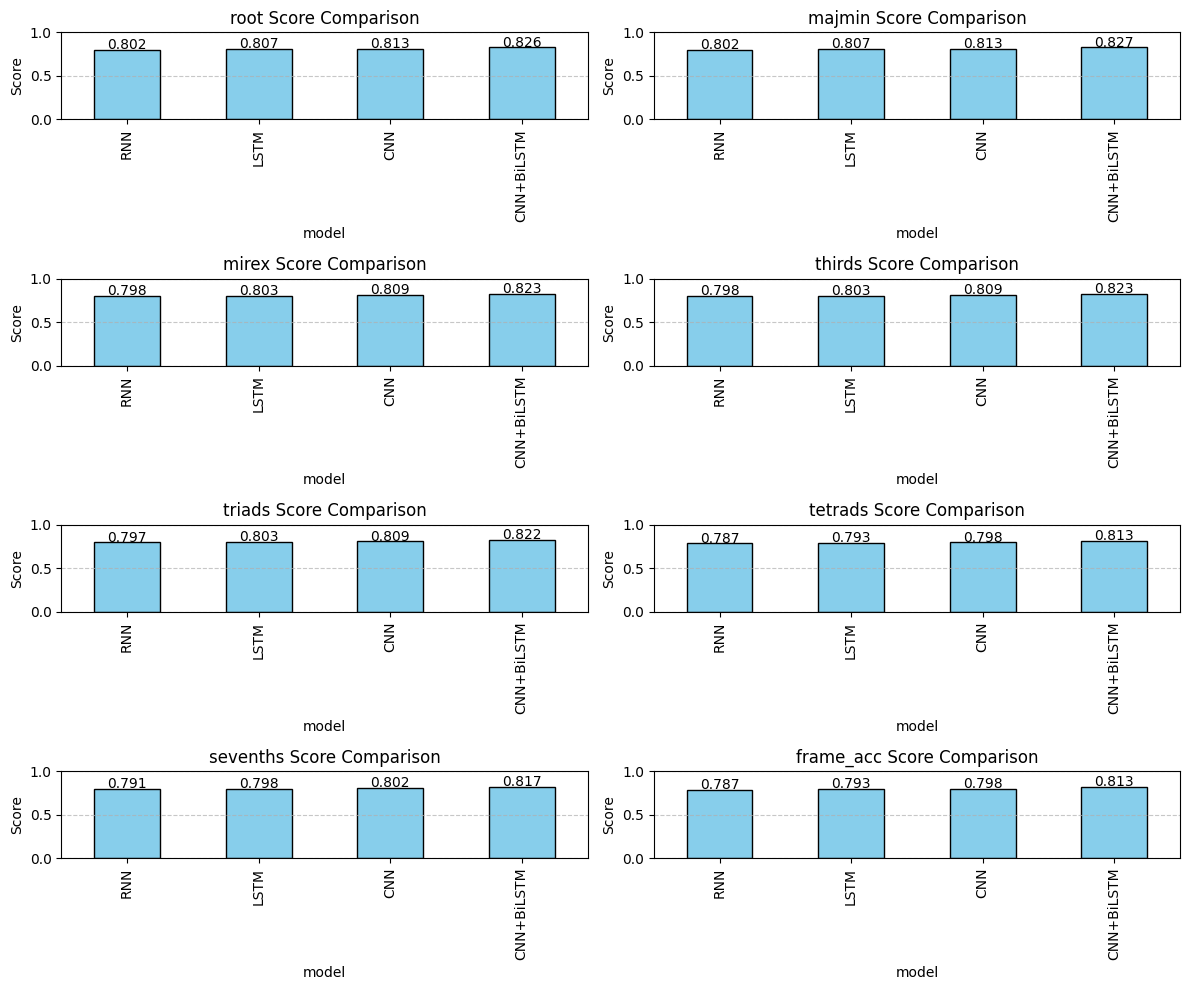

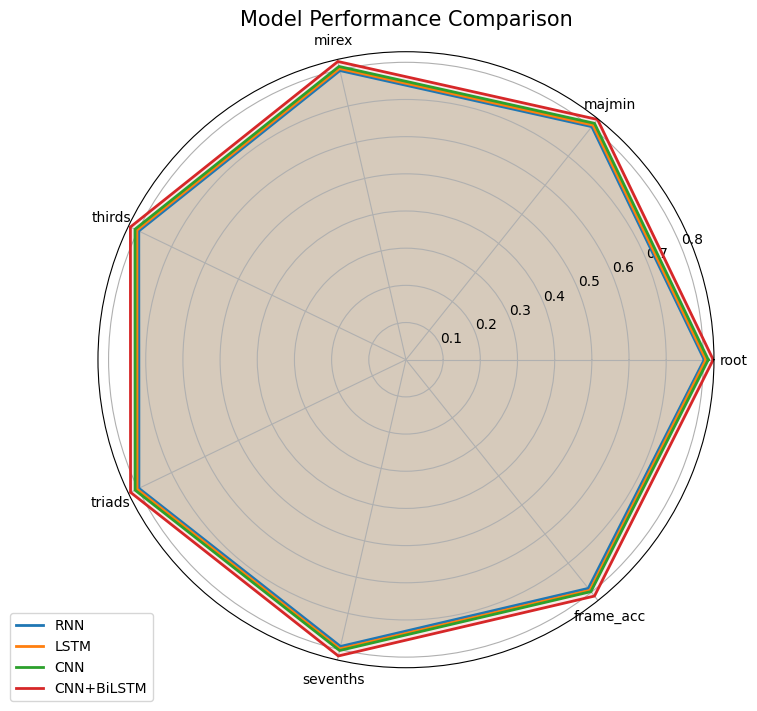

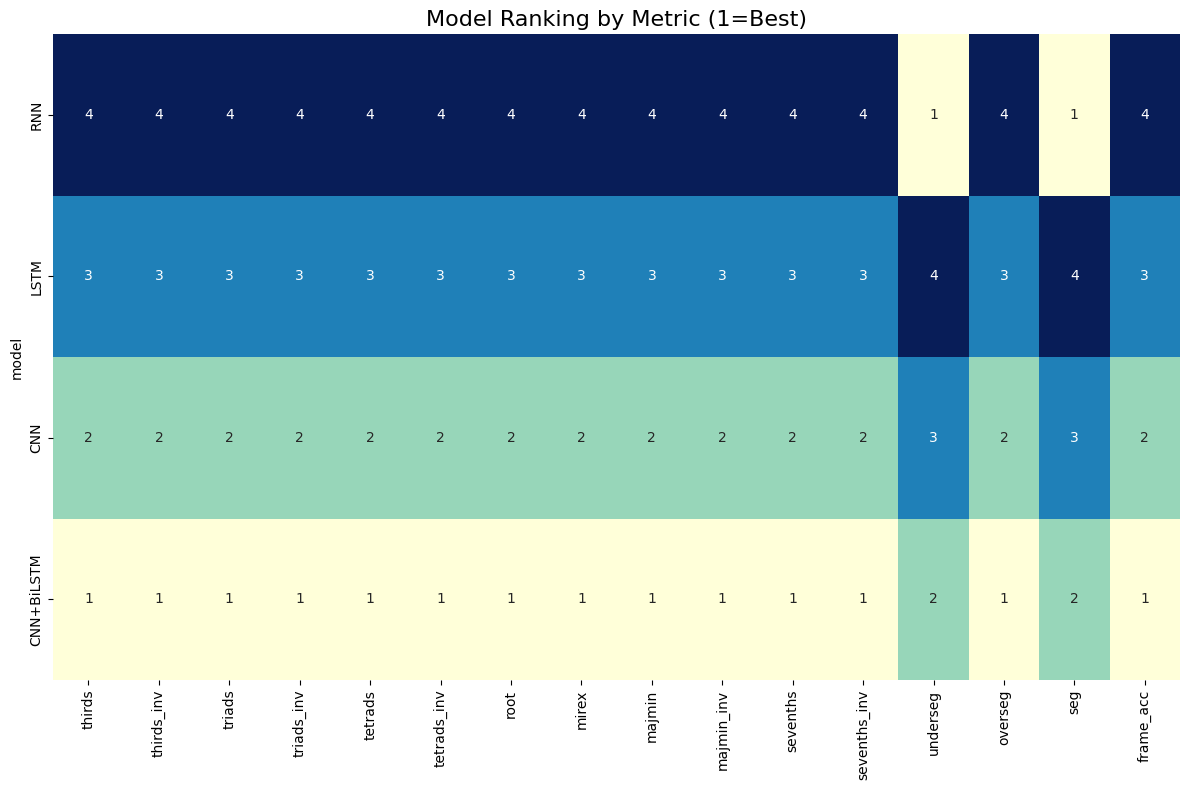

In [70]:
# show plotting

# confusion matrices
confusion_fig = plot_confusion_matrices(models, X_te, y_te, pad_id, top_n_classes=8)
plt.savefig('confusion_matrices.png', bbox_inches='tight', dpi=300)
plt.show()

# performance bar charts
performance_fig = plot_performance_comparison(df)
plt.savefig('performance_comparison.png', bbox_inches='tight', dpi=300)
plt.show()

# radar chart for general comparison
radar_fig = plot_radar_chart(df)
plt.savefig('radar_comparison.png', bbox_inches='tight', dpi=300)
plt.show()

# model rank by metric
def plot_model_ranks(df):
    rank_df = df.rank(ascending=False).astype(int)
    fig, ax = plt.subplots(figsize=(12, 8))
    sns.heatmap(rank_df, annot=True, cmap="YlGnBu", fmt='d', cbar=False)
    
    plt.title('Model Ranking by Metric (1=Best)', fontsize=16)
    plt.tight_layout()
    return fig

rank_fig = plot_model_ranks(df)
plt.savefig('model_rankings.png', bbox_inches='tight', dpi=300)
plt.show()